In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!sudo apt install git-lfs
!git lfs version
!rm -rf ml
!mkdir ml
!cd ml
!git init
!git lfs install
!git clone https://github.com/kokoichi206/ml.git
!git fetch
!cd ..
!ls -la ml/akimoto/
!mv ml/akimoto/saka.zip saka.zip
!mv ml/akimoto/akb.zip akb.zip

!rm -rf akb_pre
!rm -rf saka_pre

!ls
!yes | unzip akb.zip > /dev/null
!yes | unzip saka.zip > /dev/null

!ls akb_pre | wc
!ls saka_pre | wc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.3.4-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
git-lfs/2.3.4 (GitHub; linux amd64; go 1.8.3)
Reinitialized existing Git repository in /content/.git/
Updated git hooks.
Git LFS initialized.
Cloning into 'ml'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 79 (delta 19), reused 73 (delta 16), pack-reused 0
Unpacking objects: 100% (79/79), done.
Filtering content: 100% (3/3), 88.76 MiB | 60.92 MiB/s, done.
total 90952
drwxr-xr-x 4 root root     4096 Jan  1 00:14 .
drwxr-xr-x 4 root root     4096 Jan  1 00:14 ..
-rw-r--r-- 1 root root 35182017 Jan  1 00:14 akb.zip
-rw-r--r-- 1 root root     2443 Jan  1 00:14 get_names.py
-rw-r--r-- 1 root root       42 Jan  1 00:14 .gitattributes
-rw-r--r-- 1 root root       26 Jan  1 00:14 .giti

In [3]:
!ls akb_pre | wc
!ls saka_pre | wc

   3847    3847   42325
   3928    3928   43216


In [4]:
from PIL import Image
import numpy as np
import glob
import gc


groups = ["akb", "saka"]

akbs = glob.glob("akb_pre/*.jpg")
sakas = glob.glob("saka_pre/*.jpg")
faces = []
cnt = 0

print(np.asarray(Image.open(akbs[0]), np.uint8).shape)


for path in akbs:
    cnt += 1
    with Image.open(path) as img:
        # colabでリサイズする場合
        # orig = img.resize((64, 64), Image.LANCZOS)
        faces.append(np.asarray(img, np.uint8))

for path in sakas:
    cnt += 1
    with Image.open(path) as img:
        faces.append(np.asarray(img, np.uint8))

X = np.array(faces)
# 正解ラベルを作成する
len_akbs = len(akbs)
len_sakas = len(sakas)
y = np.zeros((len_akbs+len_sakas, 2))
for i in range(len_akbs):
    y[i, 0] = 1
for j in range(len(sakas)):
    y[j+len_akbs, 1] = 1

(128, 128, 3)


In [5]:
print(X.shape)
print(y.shape)
print(X.shape[1])

(7775, 128, 128, 3)
(7775, 2)
128


In [6]:
import tensorflow as tf
import tensorflow.keras.layers as layers

IMG_SIZE = X.shape[1]
inputs = layers.Input((IMG_SIZE,IMG_SIZE,3))
## １層目
x = layers.Conv2D(64, 3, padding="same")(inputs)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(64, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.AveragePooling2D(2)(x)
## 2層目
x = layers.Conv2D(128, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(128, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.AveragePooling2D(2)(x)
## 3層目
x = layers.Conv2D(256, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(256, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.AveragePooling2D(2)(x)

# # ## 4層目
# x = layers.Conv2D(512, 3, padding="same")(x)
# x = layers.BatchNormalization()(x)
# x = layers.ReLU()(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(2, activation="softmax")(x)

model = tf.keras.models.Model(inputs, x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                             

In [7]:
from sklearn.model_selection import train_test_split

def create_dataset(X, y, test_size=0.2, random_state=123):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    return X_train.astype(np.float32) / 255.0, X_test.astype(np.float32) / 255.0, y_train.astype(np.float32), y_test.astype(np.float32)

In [8]:
import matplotlib.pyplot as plt


model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.save_weights('/content/drive/MyDrive/Colab Notebooks/akimoto/models')

batch_size = 256
epochs = 33
seeds = [3, 123, 44, 77]
len_seeds = len(seeds)

train_losses = []
train_acces = []
val_losses = []
val_acces = []
# for seed in 
for i in range(len_seeds):
    X_train, X_test, y_train, y_test = create_dataset(X, y, random_state=seeds[i])

    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)

    train_losses += history.history['loss'] 
    train_acces += history.history['accuracy'] 
    val_losses += history.history['val_loss'] 
    val_acces += history.history['val_accuracy']

model.save_weights('/content/drive/MyDrive/Colab Notebooks/akimoto/models_4th')

Epoch 1/33
25/25 [==============================] - 26s 542ms/step - loss: 0.7460 - accuracy: 0.5645 - val_loss: 0.6930 - val_accuracy: 0.4984
Epoch 2/33
25/25 [==============================] - 12s 468ms/step - loss: 0.6563 - accuracy: 0.6183 - val_loss: 0.6917 - val_accuracy: 0.5209
Epoch 3/33
25/25 [==============================] - 12s 470ms/step - loss: 0.6515 - accuracy: 0.6198 - val_loss: 0.6909 - val_accuracy: 0.5312
Epoch 4/33
25/25 [==============================] - 12s 494ms/step - loss: 0.6434 - accuracy: 0.6280 - val_loss: 0.6979 - val_accuracy: 0.4977
Epoch 5/33
25/25 [==============================] - 12s 489ms/step - loss: 0.6369 - accuracy: 0.6352 - val_loss: 0.6935 - val_accuracy: 0.5260
Epoch 6/33
25/25 [==============================] - 12s 463ms/step - loss: 0.6361 - accuracy: 0.6341 - val_loss: 0.7596 - val_accuracy: 0.4958
Epoch 7/33
25/25 [==============================] - 12s 464ms/step - loss: 0.6343 - accuracy: 0.6397 - val_loss: 0.7007 - val_accuracy: 0.4958

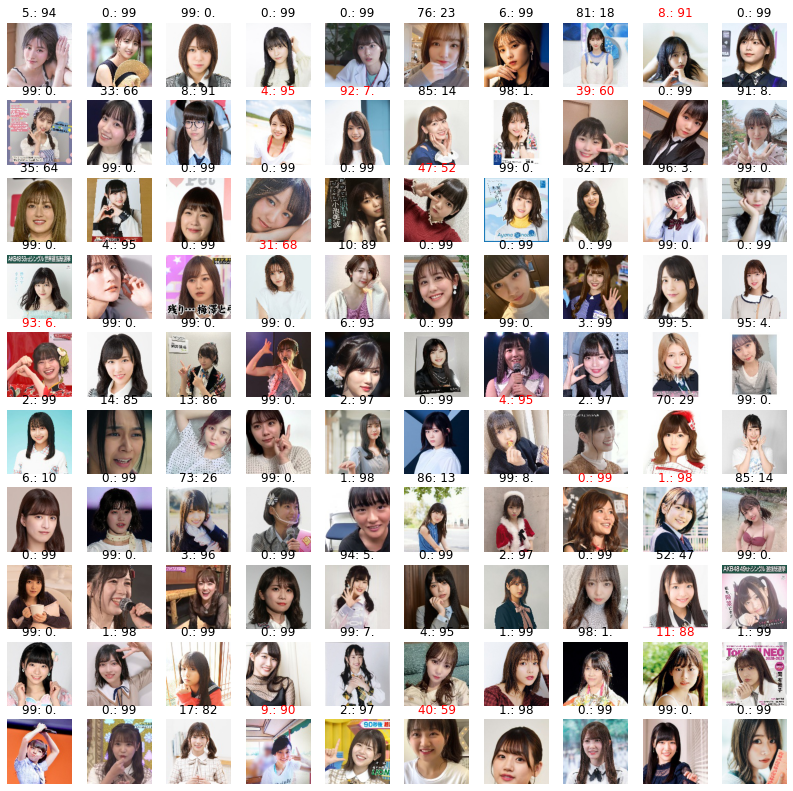

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14,14))
y_raw = model.predict(X_test)
y_pred = np.argmax(y_raw, axis=-1) # argmaxでラベルを取る
y_correct = np.argmax(y_test, axis=-1)

for i in range(100):
    ax = fig.add_subplot(10, 10, i+1)
    ax.imshow(X_test[i])
    ax.axis("off")

    akb_percentage = str(100*y_raw[i][0])[:2]
    saka_percentage = str(100*y_raw[i][1])[:2]
    if y_pred[i] == y_correct[i]:
        ax.set_title(f"{akb_percentage}: {saka_percentage}")
    else:
        ax.set_title(f"{akb_percentage}: {saka_percentage}", color="red")


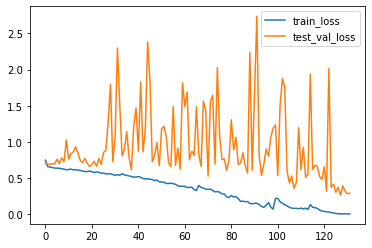

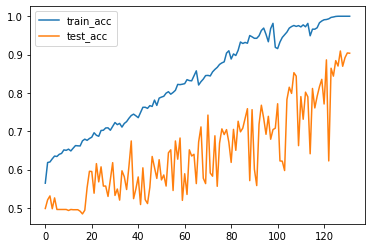

In [9]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(train_losses)), train_losses, label='train_loss')
plt.plot(np.arange(len(val_losses)), val_losses, label='test_val_loss')
plt.legend()
plt.show()

plt.plot(np.arange(len(train_acces)), train_acces, label='train_acc')
plt.plot(np.arange(len(val_acces)), val_acces, label='test_acc')
plt.legend()
plt.show()